In [1]:
!nvidia-smi

Tue Dec 22 16:28:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt-get install nvidia-cuda-toolkit
!pip install numba

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-6 fonts-dejavu-core fonts-dejavu-extra g++-6 gcc-6 gcc-6-base
  libaccinj64-9.1 libasan3 libatk-wrapper-java libatk-wrapper-java-jni
  libcublas9.1 libcudart9.1 libcufft9.1 libcufftw9.1 libcuinj64-9.1
  libcurand9.1 libcusolver9.1 libcusparse9.1 libgail-common libgail18
  libgcc-6-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libnppc9.1
  libnppial9.1 libnppicc9.1 libnppicom9.1 libnppidei9.1 libnppif9.1
  libnppig9.1 libnppim9.1 libnppist9.1 libnppisu9.1 libnppitc9.1 libnpps9.1
  libnvblas9.1 libnvgraph9.1 libnvrtc9.1 libnvtoolsext1 libnvvm3
  libstdc++-6-dev libthrust-dev libvdpau-dev libxxf86dga1 nvidia-cuda-dev
  nvidia-cuda-doc nvidia-cuda-gdb nvidia-profiler nvidia-visual-profiler
  openjdk-8-jre openjdk-8-jre-headless x11-utils
Suggested packages:
  gcc-6-locales g++-6-multilib gcc-6-doc libstdc++6-6-dbg gcc-6-multilib
  libgc

In [3]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/lib/cuda/nvvm/libdevice
/usr/lib/nvidia-cuda-toolkit/libdevice
find: ‘/proc/535/task/535/net’: Invalid argument
find: ‘/proc/535/net’: Invalid argument
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
find: ‘/proc/535/task/535/net’: Invalid argument
find: ‘/proc/535/net’: Invalid argument


In [4]:
import os


os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.1/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so"

## Classes

In [173]:
NUM_GENERATIONS = 6000
NUM_PARENT_MATING = 300
NUM_POPULATION = 6000

In [174]:
import math
import matplotlib.pyplot as plt
from numba import cuda
import numba
import copy
import numpy as np
import time


def get_input_data(sol_per_pop: int = NUM_POPULATION) -> tuple:
    """ Функция возвращает случайно сгенерированную начальную популяцию

        params:
            sol_per_pop: int - количество особей в начальной популяции
    """

    true_weights = np.array([0.4, -2, 3.5, 3])
    num_weights = len(true_weights)

    pop_size = (sol_per_pop, num_weights)
    new_population = np.random.uniform(low=min(true_weights)-0.1, high=max(true_weights)+0.1, size=pop_size)

    threads_per_block = 256
    blocks_per_grid = (sol_per_pop * num_weights + (threads_per_block - 1))

    fitnesses = np.zeros((sol_per_pop, ))
    offspring = np.zeros((pop_size[0] - NUM_PARENT_MATING, num_weights)).astype(np.float32)

    return new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid

In [8]:
from abc import ABC, abstractmethod

class AbstractAlgo(ABC):
    def __init__(self, num_generations, num_parents_mating):
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating

    @abstractmethod
    def calculate_fitness(self):
        pass

    @abstractmethod
    def select_mating_pool(self):
        pass

    @abstractmethod
    def crossover(self):
        pass

    @abstractmethod
    def mutation(self):
        pass

    @abstractmethod
    def run(self):
        pass

    def display_results(self):
        best_individual, ground_truth = self.run()
        print("Best solution : ", best_individual)
        print("Ground_truth : ", ground_truth)

        X = list(range(0, 10))
        y = [
            ground_truth[0] * math.pow(x, 4) + 
            ground_truth[1] * math.pow(x, 3) + 
            ground_truth[2] * math.pow(x, 2) + 
            ground_truth[3] * x for x in X
        ]

        y_pred = [
            best_individual[0] * math.pow(x, 4) + 
            best_individual[1] * math.pow(x, 3) + 
            best_individual[2] * math.pow(x, 2) + 
            best_individual[3] * x for x in X
        ]

        plt.plot(X, y, label='true')
        plt.plot(X, y_pred, label='predicted')
        plt.legend()

In [120]:
class CPUAlgo(AbstractAlgo):

    def calculate_fitness(self, true_weights: list, pop: np.ndarray) -> list:
        """ Вычисляет mape для каждой особи

            params:
                true_weights: истинная особь
                pop: популяция
        """
        fitness = []
        for p in pop:
            mape = sum([abs(true_weights[i] - p[i]) / (abs(true_weights[i]) + 1e-6) for i in range(len(true_weights))])
            fitness.append(mape)
        return fitness

    def select_mating_pool(self, pop: np.ndarray, fitness: list, num_parents: int) -> np.ndarray:
        """ Отбор лучших особей в текущем поколении в качестве родителей 
            для производства потомства следующего поколения

            params:
                pop: популяция
                fitness: значение потерь каждой особи
                num_parents: количество особей, которые будут отобраны
        """
        parents = np.empty((num_parents, pop.shape[1]))
        first = True
        for parent_num in range(num_parents):
            max_fitness_idx = np.argmin(fitness)
            parents[parent_num, :] = pop[max_fitness_idx, :]
            fitness[max_fitness_idx] = 99999999999
        return parents

    def crossover(self, parents: np.ndarray, offspring_size: np.ndarray) -> np.ndarray:
        """ Совмещение генов родителей, для каждой пары родителей появляется
            появляется потомок, который наследует гены от родителей
            (первая половина от 1-го, вторая половина от 2-го)

            params:
                parents: родители
                offspring_size: число наследников
        """
        offspring = np.empty(offspring_size)
        crossover_point = np.uint8(offspring_size[1]/2)

        for k in range(offspring_size[0]):
            parent1_idx = k % parents.shape[0]
            parent2_idx = (k + 1) % parents.shape[0]
            offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

        return offspring

    def mutation(self, offspring_crossover: np.ndarray) -> np.ndarray:
        """ Мутация изменяет один ген в каждом потомстве случайным образом.
            Случайная величина, которая должна быть добавлена к гену.
            
            params:
                offspring_crossover: скрещенные особи
        """
        for idx in range(offspring_crossover.shape[0]):
            for random_index in np.random.randint(0, 3, size=3):
                random_value = np.random.uniform(-1.0, 1.0, 1)
                offspring_crossover[idx, random_index] += random_value

        return offspring_crossover

    def run(self) -> tuple:
        """ Обучение генетического алгоритма
        """
        new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()
        parents = np.zeros((NUM_PARENT_MATING, new_population.shape[1]))

        min_fitness = 99999999999
        tol = 0
        tol_iter = 5

        t1 = time.time()
        for generation in range(self.num_generations):
            fitness = self.calculate_fitness(true_weights, new_population)

            parents = self.select_mating_pool(new_population, fitness, 
                                            self.num_parents_mating)
            
            offspring_crossover = self.crossover(parents,
                                            offspring_size=offspring.shape)
            
            offspring_mutation = self.mutation(offspring_crossover)

            new_population[:parents.shape[0], :] = parents
            new_population[parents.shape[0]:, :] = offspring_mutation

            best_fitness = min(fitness)
            if best_fitness < min_fitness:
                min_fitness = best_fitness
                tol = 0
                print("*** Новая лучшая ошибка: ", min_fitness)
            else:
                tol += 1
            
            if tol == tol_iter:
                print(f"*** Ошибка не улучшалась {tol_iter} итераций подряд, обучение прервано")
                break

        print("time, s: ", round(time.time() - t1, 2))

        idx = np.argmin(fitnesses)
        return new_population[idx], true_weights

In [121]:
class GPUAlgo(AbstractAlgo):

    @cuda.jit
    def calculate_fitness(self, true_weights, pop, fitness):
        """ Вычисляет mape для каждой особи

            params:
                true_weights: истинная особь
                pop: популяция
                fitness: значение потерь каждой особи
        """
        tx = cuda.threadIdx.x
        bx = cuda.blockIdx.x
        bw = cuda.blockDim.x
        i = tx + bx * bw

        if i < pop.shape[0]:
            for j in range(len(true_weights)):
                fitness[i] += abs(true_weights[j] - pop[i][j]) / (abs(true_weights[j]) + 1e-6)
                numba.cuda.syncthreads()

    @cuda.jit
    def select_mating_pool(self, pop, fitness, num_parents, parents):
        """ Отбор лучших особей в текущем поколении в качестве родителей 
            для производства потомства следующего поколения

            params:
                pop: популяция
                fitness: значение потерь каждой особи
                num_parents: количество особей, которые будут отобраны
                parents: особи, которые будут отобраны
        """
        tx = cuda.threadIdx.x
        bx = cuda.blockIdx.x
        bw = cuda.blockDim.x
        i = tx + bx * bw

        if i < num_parents:
            max_fitness_idx = fitness.argmin()
            for point in range(parents.shape[1]):
                parents[i, point] = pop[max_fitness_idx, point]
            fitness[max_fitness_idx] = 99999999999

    @cuda.jit('void(int32, float32[:,:], float32[:,:])')
    def crossover(self, parents, offspring):
        """ Совмещение генов родителей, для каждой пары родителей появляется
            появляется потомок, который наследует гены от родителей
            (первая половина от 1-го, вторая половина от 2-го)

            params:
                parents: родители
                offspring: наследники
        """
        tx = cuda.threadIdx.x
        bx = cuda.blockIdx.x
        bw = cuda.blockDim.x
        i = tx + bx * bw
        # offspring = np.empty(offspring_size)
        # Точка, в которой происходит скрещивание между двумя родителями
        crossover_point = np.uint8(offspring.shape[1]/2)
        inverse_point = np.uint8(offspring.shape[1] - crossover_point)

        if i < offspring.shape[0]:
            parent1_idx = i % parents.shape[0]
            parent2_idx = (i + 1) % parents.shape[0]

            for point in range(crossover_point):
                offspring[i, point] = parents[parent1_idx, point]
                numba.cuda.syncthreads()
                
            for point in range(inverse_point):
                offspring[i, offspring.shape[1]-point-1] = parents[parent1_idx, offspring.shape[1]-point-1]
                numba.cuda.syncthreads()

    @cuda.jit('void(int32, float32[:,:], int32[:], float32)')
    def mutation(self, offspring_crossover, random_indexes, random_value):
        """ Мутация изменяет один ген в каждом потомстве случайным образом.
            Случайная величина, которая должна быть добавлена к гену.
            
            params:
                offspring_crossover: скрещенные особи
                random_indexes: массив случайных индексов с диапазоном значений
                                от 0 до 3
                random_value: случайное число с плавающей точкой
        """
        tx = cuda.threadIdx.x
        bx = cuda.blockIdx.x
        bw = cuda.blockDim.x
        i = tx + bx * bw

        if i < offspring_crossover.shape[0]:
            for j in range(random_indexes.shape[0]):
                offspring_crossover[i, random_indexes[j]] = random_value

    def run(self) -> tuple:
        """ Обучение генетического алгоритма
        """
        new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()
        parents = np.zeros((self.num_parents_mating, new_population.shape[1]))

        min_fitness = 99999999999
        tol = 0
        tol_iter = 5

        t1 = time.time()
        for generation in range(self.num_generations):
            # Измерение fitness-значеня каждой хромосомы в популяции
            self.calculate_fitness[blocks_per_grid, threads_per_block](0, true_weights, new_population, fitnesses)

            # Отбор лучших родителей в популяции для скрещивания
            self.select_mating_pool[blocks_per_grid, threads_per_block](0, new_population, fitnesses, 
                                            self.num_parents_mating, parents)
            
            # Генерация следующего поколения с использованием скрещивания
            self.crossover[blocks_per_grid, threads_per_block](0, parents,
                                            offspring)
            
            # Мутация
            # rng_states = numba.cuda.random.create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=1)
            # mutation[blocks_per_grid, threads_per_block](rng_states, offspring)
            # offspring_mutation = self.mutation(offspring)
            random_indexes = np.random.randint(0, 3, size=3)
            random_value = np.random.uniform(-1.0, 1.0, 1)
            self.mutation[blocks_per_grid, threads_per_block](0, offspring, random_indexes, random_value)

            # Создание новой популяции на основе родителей и потомства
            new_population[:parents.shape[0], :] = parents
            new_population[parents.shape[0]:, :] = offspring

            best_fitness = min(fitnesses)
            if best_fitness < min_fitness:
                min_fitness = best_fitness
                tol = 0
                print("*** Новая лучшая ошибка: ", min_fitness)
            else:
                tol += 1
            
            if tol == tol_iter:
                print(f"*** Ошибка не улучшалась {tol_iter} итераций подряд, обучение прервано")
                break

        print("time, s: ", round(time.time() - t1, 2))
        idx = np.argmin(fitnesses)
        return new_population[idx], true_weights

*** Новая лучшая ошибка:  0.6817533352659245
*** Ошибка не улучшалась 5 итераций подряд, обучение прервано
time, s:  0.06
Best solution :  [ 0.39692954 -1.96528173  3.51467497  1.22356207]
Ground_truth :  [ 0.4 -2.   3.5  3. ]


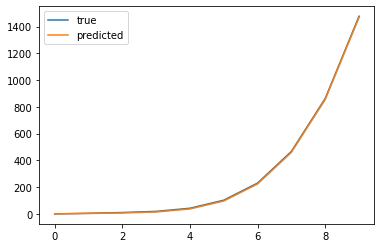

In [184]:
gpu_gen_algo = GPUAlgo(NUM_GENERATIONS, NUM_PARENT_MATING)

gpu_gen_algo.display_results()

*** Новая лучшая ошибка:  2.8133994887946097
*** Новая лучшая ошибка:  1.0589107543517864
*** Новая лучшая ошибка:  0.5155850504746174
*** Новая лучшая ошибка:  0.3161644475650693
*** Новая лучшая ошибка:  0.2404673217552788
*** Новая лучшая ошибка:  0.19364253302042297
*** Новая лучшая ошибка:  0.16134978681960327
*** Новая лучшая ошибка:  0.14020601483835227
*** Новая лучшая ошибка:  0.12843470138266172
*** Новая лучшая ошибка:  0.11611289536242188
*** Новая лучшая ошибка:  0.10730667328194857
*** Новая лучшая ошибка:  0.09961879316788508
*** Новая лучшая ошибка:  0.09202072608299988
*** Новая лучшая ошибка:  0.08603233684357037
*** Новая лучшая ошибка:  0.07945760629333434
*** Новая лучшая ошибка:  0.07366803867534387
*** Новая лучшая ошибка:  0.06974078869284772
*** Новая лучшая ошибка:  0.06563688397368656
*** Новая лучшая ошибка:  0.06297049681761556
*** Новая лучшая ошибка:  0.05915783925149259
*** Новая лучшая ошибка:  0.055333269731943115
*** Новая лучшая ошибка:  0.0535654267

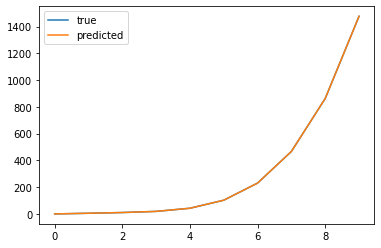

In [177]:
cpu_gen_algo = CPUAlgo(NUM_GENERATIONS, NUM_PARENT_MATING)

cpu_gen_algo.display_results()

## Benchmarks

### fitness

In [185]:
new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()


costs_gpu = []
costs_cpu = []
for _ in range(100):
    t1 = time.time()
    gpu_gen_algo.calculate_fitness[blocks_per_grid, threads_per_block](0, true_weights, new_population, fitnesses)
    costs_gpu.append(time.time() - t1)

    t1 = time.time()
    cpu_gen_algo.calculate_fitness(true_weights, new_population)
    costs_cpu.append(time.time() - t1)

print(f"Среднее время расчета ошибки по всей популяции на GPU: {np.mean(costs_gpu)} на CPU: {np.mean(costs_cpu)} (сек)")

Среднее время расчета ошибки по всей популяции на GPU: 0.0017502474784851074 на CPU: 0.0320620059967041 (сек)


### select

In [186]:
new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()
parents = np.zeros((NUM_PARENT_MATING, new_population.shape[1]))

costs_gpu = []
costs_cpu = []
for i in range(100):
    t1 = time.time()
    gpu_gen_algo.select_mating_pool[blocks_per_grid, threads_per_block](0, new_population, fitnesses, 
                                            NUM_PARENT_MATING, parents)
    costs_gpu.append(time.time() - t1)

    t1 = time.time()
    cpu_gen_algo.select_mating_pool(new_population, fitnesses, 
                                      NUM_PARENT_MATING)
    costs_cpu.append(time.time() - t1)

print(f"Среднее время выборки лучших особей на GPU: {np.mean(costs_gpu)} на CPU: {np.mean(costs_cpu)} (сек)")

Среднее время выборки лучших особей на GPU: 0.0036290717124938966 на CPU: 0.0028832316398620605 (сек)


### crossover

In [187]:
new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()
parents = np.zeros((NUM_PARENT_MATING, new_population.shape[1]))

costs_gpu = []
costs_cpu = []
for i in range(100):
    t1 = time.time()
    gpu_gen_algo.crossover[blocks_per_grid, threads_per_block](0, parents,
                                            offspring)
    costs_gpu.append(time.time() - t1)

    t1 = time.time()
    cpu_gen_algo.crossover(parents, offspring_size=offspring.shape)
    costs_cpu.append(time.time() - t1)

print(f"Среднее время рассчета кроссовера на GPU: {np.mean(costs_gpu)} на CPU: {np.mean(costs_cpu)} (сек)")

Среднее время рассчета кроссовера на GPU: 0.0012002086639404297 на CPU: 0.01029716968536377 (сек)


### mutation

In [188]:
new_population, true_weights, fitnesses, offspring, threads_per_block, blocks_per_grid = get_input_data()
parents = np.zeros((NUM_PARENT_MATING, new_population.shape[1]))

costs_gpu = []
costs_cpu = []
for i in range(100):
    t1 = time.time()
    random_indexes = np.random.randint(0, 3, size=3)
    random_value = np.random.uniform(-1.0, 1.0, 1)
    gpu_gen_algo.mutation[blocks_per_grid, threads_per_block](0, offspring, random_indexes, random_value)
    costs_gpu.append(time.time() - t1)

    t1 = time.time()
    cpu_gen_algo.mutation(offspring)
    costs_cpu.append(time.time() - t1)

print(f"Среднее время мутации на GPU: {np.mean(costs_gpu)} на CPU: {np.mean(costs_cpu)} (сек)")

Среднее время мутации на GPU: 0.0013675832748413087 на CPU: 0.18416481018066405 (сек)


### result

In [191]:
import pandas as pd

res = pd.DataFrame(
    columns=[
             'num generations',
             'num parents',
             'fitness CPU',
             'fitness GPU',
             'select CPU',
             'select GPU',
             'crossover CPU',
             'crossover GPU',
             'mutation CPU',
             'mutation GPU'
    ]
)

res['num generations'] = [500, 2000, 6000, 500, 6000, 6000]
res['num parents'] = [10, 10, 10, 50, 100, 300]
res['num population'] = [1000, 1000, 1000, 1000, 3000, 6000]

res['fitness CPU'] = [0.0057, 0.0058, 0.0054, 0.0056, 0.0154, 0.0320]
res['fitness GPU'] = [0.0016, 0.0017, 0.0015, 0.0016, 0.0016, 0.0017]

res['select CPU'] = [0.00006, 0.00007, 0.0007, 0.0002, 0.0006, 0.0028]
res['select GPU'] = [0.0016, 0.0018, 0.0016, 0.0018, 0.002, 0.0036]

res['crossover CPU'] = [ 0.0017, 0.0018, 0.0018, 0.0016, 0.004, 0.0102]
res['crossover GPU'] = [0.0010, 0.0012, 0.0010, 0.0010, 0.0010, 0.0012]

res['mutation CPU'] = [0.0301, 0.0313, 0.0311, 0.0328, 0.0873, 0.1841]
res['mutation GPU'] = [0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0013]

res

num generations  num parents  ...  mutation GPU  num population
0              500           10  ...        0.0011            1000
1             2000           10  ...        0.0011            1000
2             6000           10  ...        0.0011            1000
3              500           50  ...        0.0011            1000
4             6000          100  ...        0.0011            3000
5             6000          300  ...        0.0013            6000

[6 rows x 11 columns]